# Downloading the dataset

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shubhammishra1611","key":"5acbcbae0b4f44bc8f7977d36b611b68"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets list

ref                                                                   title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                      25KB  2023-04-13 09:55:16          38341       1088  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                            6KB  2023-05-28 18:26:48           6286        162  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                22KB  2023-05-12 13:06:39           7948        167  1.0              
mohithsairamreddy/salary-data                

In [8]:
!kaggle datasets download -d arnaud58/selfie2anime

100% 390M/390M [00:12<00:00, 40.7MB/s]
100% 390M/390M [00:12<00:00, 33.7MB/s]


In [9]:
!unzip selfie2anime.zip

Streaming output truncated to the last 5000 lines.
  inflating: trainA/female_26057.jpg  
  inflating: trainA/female_26059.jpg  
  inflating: trainA/female_26076.jpg  
  inflating: trainA/female_26092.jpg  
  inflating: trainA/female_26125.jpg  
  inflating: trainA/female_26139.jpg  
  inflating: trainA/female_26145.jpg  
  inflating: trainA/female_26149.jpg  
  inflating: trainA/female_26157.jpg  
  inflating: trainA/female_26167.jpg  
  inflating: trainA/female_26181.jpg  
  inflating: trainA/female_26190.jpg  
  inflating: trainA/female_26195.jpg  
  inflating: trainA/female_26219.jpg  
  inflating: trainA/female_26223.jpg  
  inflating: trainA/female_26226.jpg  
  inflating: trainA/female_26227.jpg  
  inflating: trainA/female_26231.jpg  
  inflating: trainA/female_26239.jpg  
  inflating: trainA/female_26241.jpg  
  inflating: trainA/female_26247.jpg  
  inflating: trainA/female_26273.jpg  
  inflating: trainA/female_26278.jpg  
  inflating: trainA/female_26279.jpg  
  inflating: 

# Making the code and stuff

### Config

In [10]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/content"
VAL_DIR = "/content"
BATCH_SIZE = 4
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 10
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN_H = "genh.pth.tar"
CHECKPOINT_GEN_Z = "genz.pth.tar"
CHECKPOINT_CRITIC_H = "critich.pth.tar"
CHECKPOINT_CRITIC_Z = "criticz.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[
                    0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)


### dataset

In [11]:
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import os

class Horse_zebra_dataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform = None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_imgs = os.listdir(root_zebra)
        self.horse_imgs = os.listdir(root_horse)

        self.length_dataset = max(len(self.zebra_imgs), len(self.horse_imgs))

        self.zebra_len = len(self.zebra_imgs)
        self.horse_len = len(self.horse_imgs)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_imgs[index%self.zebra_len]
        horse_img = self.horse_imgs[index%self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = np.array(Image.open(zebra_path).convert("RGB"))
        horse_img = np.array(Image.open(horse_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image = zebra_img, image0=horse_img)
            zebra_img, horse_img = augmentations["image"], augmentations["image0"]

        return zebra_img, horse_img


### Discriminator

In [12]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channel, out_channel, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channel,
                out_channels=out_channel,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect"
            ),
            nn.InstanceNorm2d(out_channel),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channel, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channel,
                out_channels=features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2)
        )

        layers = []
        in_channel = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channel, feature,
                          stride=1 if feature == features[-1] else 2))
            in_channel = feature
        layers.append(
            nn.Conv2d(
                in_channels=features[-1], out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


def test():
    x = torch.randn((1, 3, 256, 256))
    model = Discriminator(in_channel=3)
    preds = model(x)
    print(preds.shape)


if __name__ == "__main__":
    test()


torch.Size([1, 1, 30, 30])


### Generator

In [13]:
import torch
import torch.nn as nn


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **
                      kwargs) if down else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)


class Residual_block(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False,
                      kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7,
                      stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True),
        )

        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2,
                          kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4,
                          kernel_size=3, stride=2, padding=1)
            ]
        )

        self.residual_block = nn.Sequential(
            *[Residual_block(num_features*4) for _ in range(num_residuals)]
        )

        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False,
                          kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False,
                          kernel_size=3, stride=2, padding=1, output_padding=1)
            ]
        )

        self.last = nn.Conv2d(
            num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect"
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.residual_block(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


def test():
    x = torch.randn((2, 3, 256, 256))
    gen = Generator(img_channels=3, num_residuals=9)
    print(gen(x).shape)


if __name__ == "__main__":
    test()


torch.Size([2, 3, 256, 256])


### Utils

In [14]:
import random
import torch
import os
import numpy as np
import torch.nn as nn
import copy


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


### train

In [17]:
!mkdir saved_images

In [19]:
import torch
import sys
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image


def train_fn(disc_H, disc_Z, gen_Z, gen_H, loader, optim_disc, optim_gen, L1_loss, mse, d_scaler, g_scaler):
    loop = tqdm(loader, leave=True)

    for idx, (zebra, horse) in enumerate(loop):
        zebra, horse = zebra.to(DEVICE), horse.to(DEVICE)

        with torch.cuda.amp.autocast():
            fake_horse = gen_H(zebra)
            D_H_real = disc_H(horse)
            D_H_fake = disc_H(fake_horse.detach())
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_fake_loss + D_H_real_loss

            fake_zebra = gen_Z(horse)
            D_Z_real = disc_Z(zebra)
            D_Z_fake = disc_H(fake_zebra.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_fake_loss + D_Z_real_loss

            D_loss = (D_H_loss+D_Z_loss)/2

        optim_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(optim_disc)
        d_scaler.update()

        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_H_fake = disc_H(fake_horse)
            D_Z_fake = disc_Z(fake_zebra)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle loss
            cycle_zebra = gen_Z(fake_horse)
            cycle_horse = gen_H(fake_zebra)
            cycle_zebra_loss = L1_loss(zebra, cycle_zebra)
            cycle_horse_loss = L1_loss(horse, cycle_horse)

            # identity loss
            identity_horse = gen_Z(zebra)
            identity_zebra = gen_H(horse)
            identity_zebra_loss = L1_loss(zebra, identity_zebra)
            identity_horse_loss = L1_loss(horse, identity_horse)

            # get all losses
            G_loss = (loss_G_H + loss_G_Z +
                      cycle_horse_loss*LAMBDA_CYCLE + cycle_zebra_loss*LAMBDA_CYCLE +
                      identity_horse_loss*LAMBDA_IDENTITY + identity_zebra_loss*LAMBDA_IDENTITY)

            optim_gen.zero_grad()
            g_scaler.scale(G_loss).backward()
            g_scaler.step(optim_gen)
            g_scaler.update()

            if idx % 200 == 0:
                save_image(fake_horse*0.5 + 0.5,
                           f"/content/saved_images/anime_{idx}.png")# horse is anime
                save_image(fake_zebra*0.5 + 0.5,
                           f"/content/saved_images/human_{idx}.png")# zebra is human


def main():
    disc_H = Discriminator(in_channel=3).to(DEVICE)
    disc_Z = Discriminator(in_channel=3).to(DEVICE)
    gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    optim_disc = optim.Adam(
        list(disc_H.parameters())+list(disc_Z.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999)
    )
    optim_gen = optim.Adam(
        list(gen_Z.parameters())+list(gen_H.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999)
    )

    L1_loss = nn.L1Loss()
    mse = nn.MSELoss()
    # "/content/trainA"
    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_CRITIC_H, disc_H, optim_disc, lr=LEARNING_RATE)
        load_checkpoint(
            CHECKPOINT_CRITIC_Z, disc_Z, optim_disc, lr=LEARNING_RATE)
        load_checkpoint(
            CHECKPOINT_GEN_H, gen_H, optim_gen, lr=LEARNING_RATE)
        load_checkpoint(
            CHECKPOINT_GEN_Z, gen_Z, optim_gen, lr=LEARNING_RATE)

    dataset = Horse_zebra_dataset(root_horse=TRAIN_DIR+"/trainA",
                                  root_zebra=TRAIN_DIR+"/trainB", transform=transforms)

    loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(disc_H, disc_Z, gen_Z, gen_H, loader, optim_disc,
                 optim_gen, L1_loss, mse, d_scaler, g_scaler)

        if SAVE_MODEL:
            save_checkpoint(gen_H, optim_gen, filename=CHECKPOINT_GEN_H)
            save_checkpoint(gen_Z, optim_gen, filename=CHECKPOINT_GEN_Z)
            save_checkpoint(disc_H, optim_disc,
                            filename=CHECKPOINT_CRITIC_H)
            save_checkpoint(disc_Z, optim_disc,
                            filename=CHECKPOINT_CRITIC_Z)


main()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 850/850 [11:46<00:00,  1.20it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 850/850 [11:46<00:00,  1.20it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 850/850 [11:47<00:00,  1.20it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 850/850 [11:46<00:00,  1.20it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 850/850 [11:46<00:00,  1.20it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 850/850 [11:46<00:00,  1.20it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 850/850 [11:46<00:00,  1.20it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 850/850 [11:46<00:00,  1.20it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 850/850 [11:46<00:00,  1.20it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 850/850 [11:45<00:00,  1.20it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


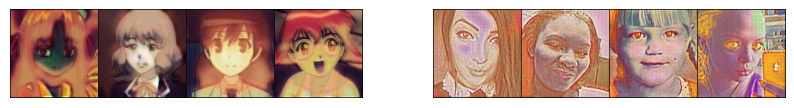

In [20]:
# import matplotlib.pyplot as plt
# path = "/content/saved_images"

# for img in os.listdir(path):
#   # if image names contains anime
#   # plot them in anime subplot
#   # else plot in human subplot
#   # complete the code

import os
import matplotlib.pyplot as plt

path = "/content/saved_images"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for img in os.listdir(path):
    if "anime" in img.lower():
        image = plt.imread(os.path.join(path, img))
        ax1.imshow(image)
        ax1.axis("off")
    else:
        image = plt.imread(os.path.join(path, img))
        ax2.imshow(image)
        ax2.axis("off")

plt.show()
